# Segerstolpe, Å. et al. Human Pancreatic Islets (SM2)

## Reference:    
[Segerstolpe, Å. et al. Single-Cell Transcriptome Profiling of Human Pancreatic Islets in Health and Type 2 Diabetes. Cell Metab. 24, 593–607 (2016)](http://dx.doi.org/10.1016/j.cmet.2016.08.020)

## ArrayExpress:    
https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-5061/

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")

from SCCAF import *

Populating the interactive namespace from numpy and matplotlib


download counts

In [2]:
cts = pd.read_csv("https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-5061/E-MTAB-5061.processed.1.zip",\
                 sep='\t',skiprows=[0], header=None, index_col=0)

In [3]:
cts.head()

,1,2,3,4,5,6,7,8,9,10,...,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029
0,,,,,,,,,,,,,,,,,,,,,
SGIP1,NM_032291,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,7,0,4,0,0,0,0
AZIN2,NM_052998+NM_001293562,0.0,0.0,0.0,0.0,0.0,41.519287,0.0,0.000000,0.000000,...,0,0,0,16,0,0,0,0,0,4
CLIC4,NM_013943,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,5.463685,...,2,20,64,18,0,0,0,0,0,1
AGBL4,NM_032785,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,5,0,0,0
NECAP2,NM_001145277+NM_001145278+NM_018090,0.0,0.0,0.0,0.0,0.0,13.992725,0.0,18.924347,44.923718,...,0,0,0,14,0,1,47,7,0,6


In [4]:
cts.shape

(26271, 7029)

In [5]:
cts1 = cts.iloc[:,3515:]

In [6]:
df = pd.read_csv("https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-5061/E-MTAB-5061.processed.1.zip",\
                 sep='\t',nrows=1, header=None, index_col=0)
cts1.columns=df.iloc[0]
cts = cts1

get annotation

In [7]:
obs = pd.read_csv("https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-5061/E-MTAB-5061.sdrf.txt",\
                 sep='\t',index_col=0)

In [8]:
ad = sc.AnnData(scipy.sparse.csr_matrix(cts.values.T))
ad.obs_names = cts.columns
ad.var_names = cts.index
ad = ad[ad.obs_names.isin(obs.index),:]
ad.obs = obs.loc[ad.obs_names]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
ad.var_names_make_unique()

In [10]:
ad.raw = sc.pp.log1p(ad,copy=True)

In [5]:
ad.obs['cell'] = ad.obs['Characteristics[cell type]']

In [6]:
ad.write("../write/Segerstolpe.h5")

In [2]:
ad = sc.read('../write/Segerstolpe.h5')

In [3]:
ad.X

<3514x26271 sparse matrix of type '<class 'numpy.float32'>'
	with 15866321 stored elements in Compressed Sparse Row format>

In [4]:
ad.raw.X

<3514x26271 sparse matrix of type '<class 'numpy.float32'>'
	with 15866321 stored elements in Compressed Sparse Row format>

In [12]:
ad = ad[:,~ad.var_names.str.startswith('ERCC')]
ad = ad[~ad.obs['Characteristics[cell type]'].astype(str).isin(['not applicable',\
                                                    'mast cell','epsilon cell',\
                                                    'MHC class II cell',\
                                                    'unclassified endocrine cell',\
                                                    'unclassified cell','co-expression cell']),:]
sc.pp.filter_cells(ad, min_genes=200)
sc.pp.filter_genes(ad, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


In [13]:
# ad.obs['n_counts'] = ad.X.sum(axis=1)

In [14]:
sc.pp.normalize_per_cell(ad, counts_per_cell_after=1e4)
sc.pp.log1p(ad)
# filter_result = sc.pp.filter_genes_dispersion(
#     ad.X, min_mean=0.4, max_mean=10, min_disp=0.35)
# sc.pl.filter_genes_dispersion(filter_result)
# print("n_HVGs: %d"%sum(filter_result.gene_subset))
# ad = ad[:, filter_result.gene_subset]
sc.pp.highly_variable_genes(ad, min_mean=0.4, max_mean=10, min_disp=0.35)

In [15]:
ad.obs['gender'] = ad.obs['Characteristics[sex]']
ad.obs['disease'] = ad.obs['Factor Value[disease]']
ad.obs['individual'] = ad.obs['Characteristics[individual]']
ad.obs['cell'] = ad.obs['Characteristics[cell type]']

In [16]:
# selected = np.std(ad.X, axis=0).argsort()[-2000:][::-1]
# ad = ad[:, selected]
ad.obs['gender'] = ad.obs['gender'].astype('category')
ad.obs['disease'] = ad.obs['disease'].astype('category')
ad.obs['individual'] = ad.obs['individual'].astype('category')
# sc.pp.log1p(ad)
sc_pp_regress_out(ad,keys=['n_counts','n_genes','individual'])
sc.pp.scale(ad, max_value=10)
sc.tl.pca(ad)

sc.tl.tsne(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.louvain(ad, resolution=1.0)

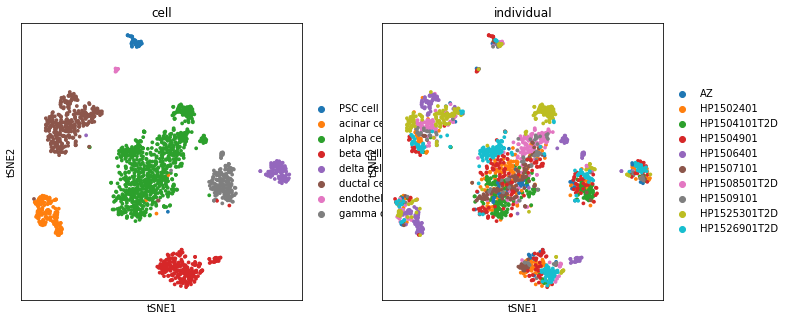

In [17]:
figsize(5,5)
sc.pl.tsne(ad, color=['cell','individual'])

In [18]:
ad.write("../write/Segerstolpe_reg.h5")

# End